In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34719")
client

Client Scheduler: tcp://127.0.0.1:34719 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 14 Cores: 70 Memory: 296.33 GB


In [2]:
import numpy as np
import xarray as xr
import gsw
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
import dask_image.ndfilters as dsfilt
import scipy.sparse as spar
import dask.array as dsar
from xhistogram.xarray import histogram as xhist
import xrft
import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [4]:
year = 1964
dnf = 2160
itime = 961200+dnf

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 15
yend = 50
sstart = 13
send = 34
nremap = 50
dnf = 2160
nchk = 20
nskip = 3

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [ ]:
ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (24,1964)), 
                     grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                     iters=int(943920+2*dnf),
                     prefix=['diag_ocnSnap'], delta_t=2e2,
                    ).sel(YC=slice(yNstart+5-12**-1,yend+2*12**-1), 
                          YG=slice(yNstart+5-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})


for itime in range(943920,itime,dnf):
    if itime == 943920:
        K = xr.open_dataset(op.join(ddir,
                                    '%4d/Diff-tensor_isig13-33_nskip3_%010d_Hann_no-smoothness.nc' 
                                    % (1963,itime))).K
    else:
        K = xr.concat([K,xr.open_dataset(op.join(ddir,
                                         '%4d/Diff-tensor_isig13-33_nskip3_%010d_Hann_no-smoothness.nc'
                                                 % (1964,itime))
                                        ).K],
                       'time').chunk({'time':1})
K

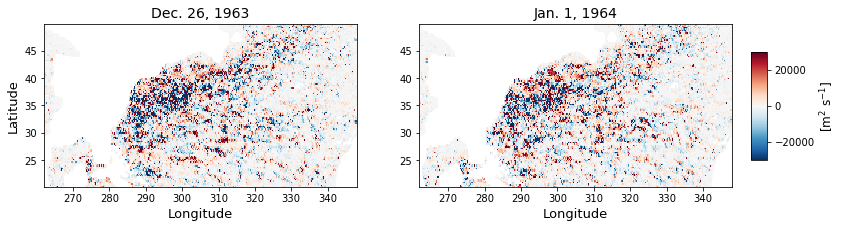

In [10]:
fig, axes = plt.subplots(figsize=(13,3), nrows=1, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                         K.isel(time=0,sig=3)[:,:,1,0].sel(YC=slice(yNstart+5,yend)), 
                         vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im1 = axes[1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                         K.isel(time=1,sig=3)[:,:,1,0].sel(YC=slice(yNstart+5,yend)), 
                         vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)


axes[0].set_title(r"Dec. 26, 1963", fontsize=14)
axes[1].set_title(r"Jan. 1, 1964", fontsize=14)

axes[0].set_xlabel(r"Longitude", fontsize=13)
axes[1].set_xlabel(r"Longitude", fontsize=13)
axes[0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.25, 0.018, 0.5])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

# plt.savefig(op.join(ddir,'Figures/Kappauu_isig17_1963-Dec-26_1964-Jan-26_no-salt-nor-smoothness.pdf'))

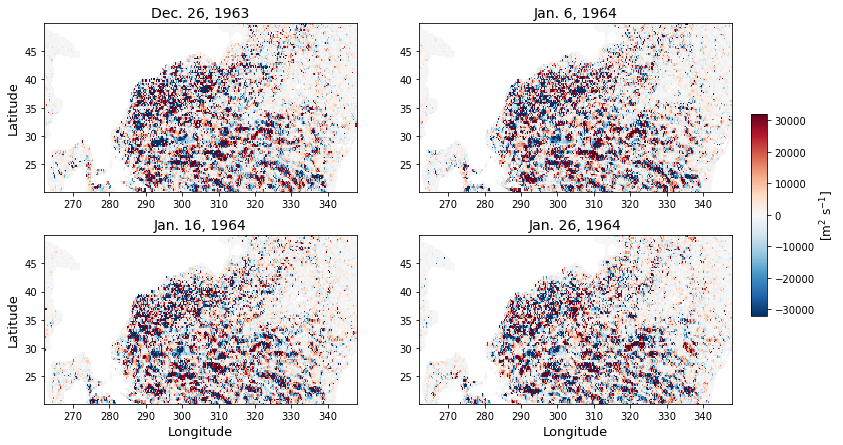

In [6]:
fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(time=0,sig=3)[:,:,0,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(time=2,sig=3)[:,:,0,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(time=4,sig=3)[:,:,0,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(time=6,sig=3)[:,:,0,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"Dec. 26, 1963", fontsize=14)
axes[0,1].set_title(r"Jan. 6, 1964", fontsize=14)
axes[1,0].set_title(r"Jan. 16, 1964", fontsize=14)
axes[1,1].set_title(r"Jan. 26, 1964", fontsize=14)


axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/Kappauu_isig17_1963-Dec-26_1964-Jan-26_Hann_no-smoothness.pdf'))

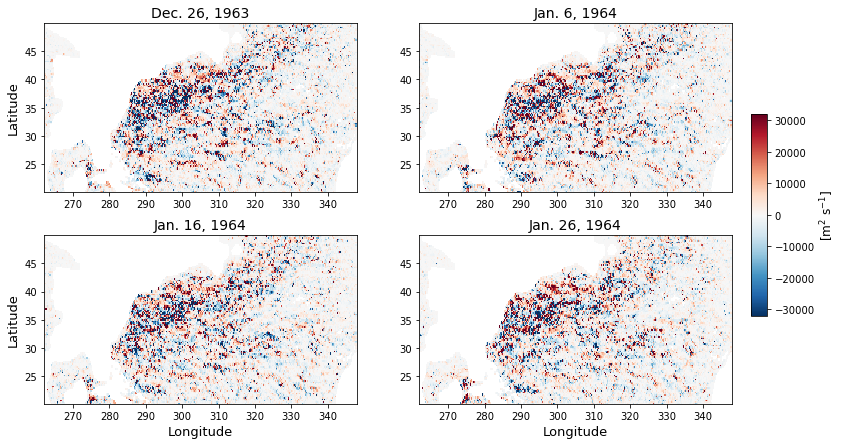

In [7]:
fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(time=0,sig=3)[:,:,1,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(time=2,sig=3)[:,:,1,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(time=4,sig=3)[:,:,1,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           K.isel(time=6,sig=3)[:,:,1,0].sel(YC=slice(yNstart+5,yend)), 
                           vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"Dec. 26, 1963", fontsize=14)
axes[0,1].set_title(r"Jan. 6, 1964", fontsize=14)
axes[1,0].set_title(r"Jan. 16, 1964", fontsize=14)
axes[1,1].set_title(r"Jan. 26, 1964", fontsize=14)


axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/Kappauv_isig17_1963-Dec-26_1964-Jan-26_Hann_no-smoothness.pdf'))

In [18]:
nhskp = 3
nremap = 80
year = 1964
dsz = xr.open_dataset(op.join(ddir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
                              % (year,nremap,itime-dnf)),
                      chunks={'nmemb':1}
                     ).isel(sig=slice(sstart,send),
                            sigp1=slice(sstart,send+1)).sel(YC=slice(yNstart+5-12**-1,yend+2*12**-1),
                                                            YG=slice(yNstart+5-12**-1,yend+2*12**-1))
dsmn = xr.open_dataset(op.join(ddir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
                               % (year,nremap,itime-dnf)),
                       chunks={'nmemb':1}
                      ).isel(sig=slice(sstart,send),
                             sigp1=slice(sstart,send+1)).sel(YC=slice(yNstart+5-12**-1,yend+2*12**-1),
                                                             YG=slice(yNstart+5-12**-1,yend+2*12**-1))
dspi = xr.open_dataset(op.join(ddir,'%4d/Varpidz-compressible_membs_parallel-%2d_%010d.nc' 
                               % (year,nremap,itime-dnf)),
                       chunks={'nmemb':1}
                      ).isel(sig=slice(sstart,send),
                             sigp1=slice(sstart,send+1)).sel(YC=slice(yNstart+5-12**-1,yend+2*12**-1))
dsep = xr.open_dataset(op.join(ddir,'%4d/E-P_flux_parallel-%2d_%010d.nc' 
                               % (year,nremap,itime-dnf)),
#                        chunks={'nmemb':1}
                      ).isel(sig=slice(sstart,send),
                             sigp1=slice(sstart,send+1)).sel(YC=slice(yNstart+5-12**-1,yend+2*12**-1),
                                                             YG=slice(yNstart+5-12**-1,yend+2*12**-1))
dsdiv = xr.open_dataset(op.join(ddir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
                                % (year,nremap,itime-dnf)),
#                         chunks={'nmemb':1}
                       ).isel(sig=slice(sstart,send),
                              sigp1=slice(sstart,send+1)).sel(YC=slice(yNstart+5-12**-1,yend+2*12**-1),
                                                              YG=slice(yNstart+5-12**-1,yend+2*12**-1))

grid = Grid(dsz, periodic=['X'], 
            coords={'Z':{'center':'sig','outer':'sigp1'},
                   'Y':{'center':'YC','left':'YG'},
                   'X':{'center':'XC','left':'XG'}}
           )

dspi

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 363, nmemb: 12, sig: 21, sigp1: 22)
Coordinates:
  * YC       (YC) float64 19.92 20.0 20.08 20.17 ... 49.83 49.92 50.0 50.08
    time     timedelta64[ns] ...
    maskInC  (YC, XC) bool dask.array<chunksize=(363, 1000), meta=np.ndarray>
    iter     int64 ...
    Depth    (YC, XC) float32 dask.array<chunksize=(363, 1000), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(363, 1000), meta=np.ndarray>
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * sig      (sig) float64 26.61 27.12 27.63 28.14 ... 35.25 35.76 36.27 36.78
  * sigp1    (sigp1) float64 26.36 26.86 27.37 27.88 ... 35.51 36.02 36.53 37.03
Data variables:
    varpidz  (nmemb, YC, XC, sig) float32 dask.array<chunksize=(1, 363, 1000, 21), meta=np.ndarray>

In [19]:
nbskp = 2
buoyb = -grav * dsz.sig[::nbskp] * rhoConst**-1
zetab = (dsz.zdz*dsz.dzetaF**-1)[:,::nhskp,::nhskp,::nbskp].mean('nmemb').compute()
# zetab

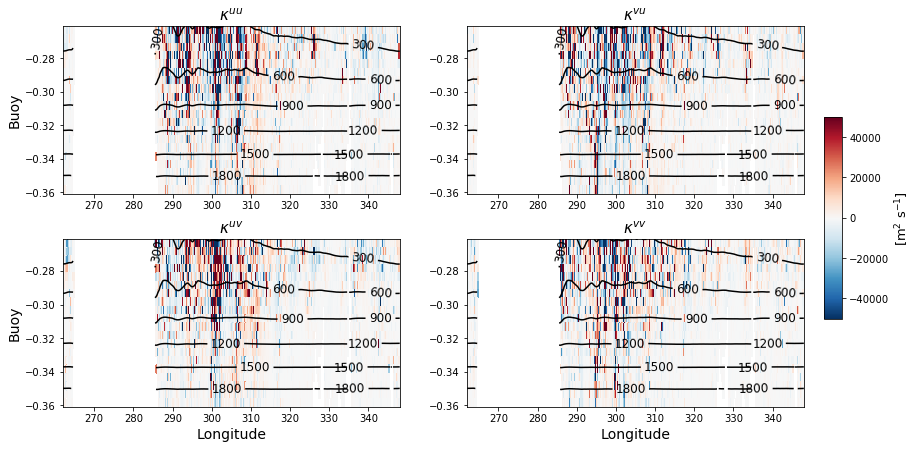

In [60]:
nlat = 37

fig, axes = plt.subplots(figsize=(14,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,0,0],
                          vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs0 = axes[0,0].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')
axes[1,0].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,1,0],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs1 = axes[1,0].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')
axes[0,1].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,0,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs2 = axes[0,1].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')
axes[1,1].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,1,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs3 = axes[1,1].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')

for c in cs0.collections:
    c.set_rasterized(True)
for c in cs1.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)

axes[0,0].clabel(cs0, inline=1, fontsize=12, fmt='%1.f')
axes[1,0].clabel(cs1, inline=1, fontsize=12, fmt='%1.f')
axes[0,1].clabel(cs2, inline=1, fontsize=12, fmt='%1.f')
axes[1,1].clabel(cs3, inline=1, fontsize=12, fmt='%1.f')

axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=15)
axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=15)
axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=15)
axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=14)
axes[1,1].set_xlabel(r"Longitude", fontsize=14)
axes[0,0].set_ylabel(r"Buoy", fontsize=14)
axes[1,0].set_ylabel(r"Buoy", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.27)
cbaxes = fig.add_axes([0.88, 0.3, 0.018, 0.4]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=13)

plt.savefig(op.join(ddir,'Figures/K_lat%2d_sig-X_1963-Dec-26.pdf' % nlat))

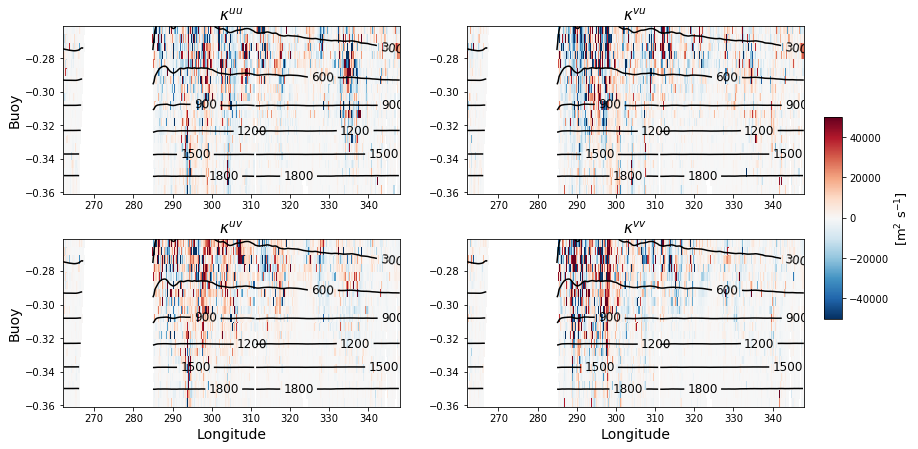

In [61]:
nlat = 35

fig, axes = plt.subplots(figsize=(14,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,0,0],
                          vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs0 = axes[0,0].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')
axes[1,0].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,1,0],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs1 = axes[1,0].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')
axes[0,1].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,0,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs2 = axes[0,1].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')
axes[1,1].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,1,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs3 = axes[1,1].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')

for c in cs0.collections:
    c.set_rasterized(True)
for c in cs1.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)

axes[0,0].clabel(cs0, inline=1, fontsize=12, fmt='%1.f')
axes[1,0].clabel(cs1, inline=1, fontsize=12, fmt='%1.f')
axes[0,1].clabel(cs2, inline=1, fontsize=12, fmt='%1.f')
axes[1,1].clabel(cs3, inline=1, fontsize=12, fmt='%1.f')

axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=15)
axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=15)
axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=15)
axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=14)
axes[1,1].set_xlabel(r"Longitude", fontsize=14)
axes[0,0].set_ylabel(r"Buoy", fontsize=14)
axes[1,0].set_ylabel(r"Buoy", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.27)
cbaxes = fig.add_axes([0.88, 0.3, 0.018, 0.4]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=13)

plt.savefig(op.join(ddir,'Figures/K_lat%2d_sig-X_1963-Dec-26.pdf' % nlat))

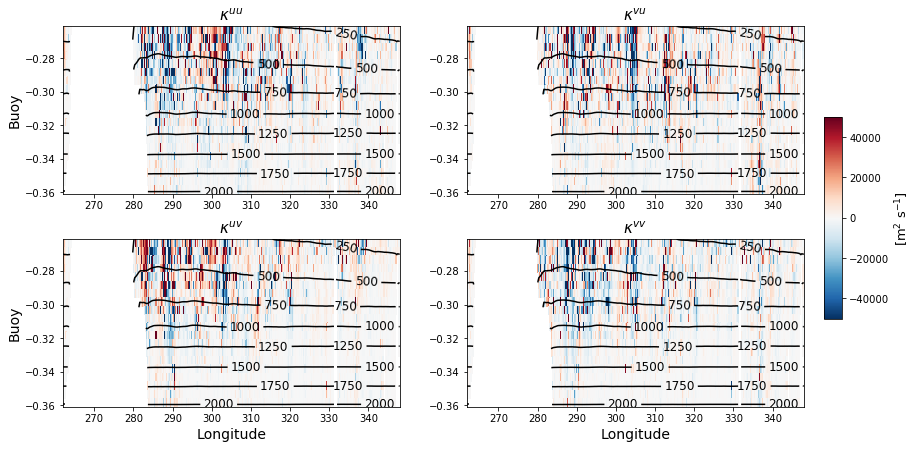

In [62]:
nlat = 30

fig, axes = plt.subplots(figsize=(14,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,0,0],
                          vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs0 = axes[0,0].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')
axes[1,0].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,1,0],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs1 = axes[1,0].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')
axes[0,1].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,0,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs2 = axes[0,1].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')
axes[1,1].pcolormesh(K.XC, buoyb, K.sel(YC=nlat,method='nearest')[:,:,1,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs3 = axes[1,1].contour(zetab.XC, buoyb, -zetab.sel(YC=nlat,method='nearest').T,
                        colors='k')

for c in cs0.collections:
    c.set_rasterized(True)
for c in cs1.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)

axes[0,0].clabel(cs0, inline=1, fontsize=12, fmt='%1.f')
axes[1,0].clabel(cs1, inline=1, fontsize=12, fmt='%1.f')
axes[0,1].clabel(cs2, inline=1, fontsize=12, fmt='%1.f')
axes[1,1].clabel(cs3, inline=1, fontsize=12, fmt='%1.f')

axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=15)
axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=15)
axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=15)
axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=14)
axes[1,1].set_xlabel(r"Longitude", fontsize=14)
axes[0,0].set_ylabel(r"Buoy", fontsize=14)
axes[1,0].set_ylabel(r"Buoy", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.27)
cbaxes = fig.add_axes([0.88, 0.3, 0.018, 0.4]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=13)

plt.savefig(op.join(ddir,'Figures/K_lat%2d_sig-X_1963-Dec-26.pdf' % nlat))

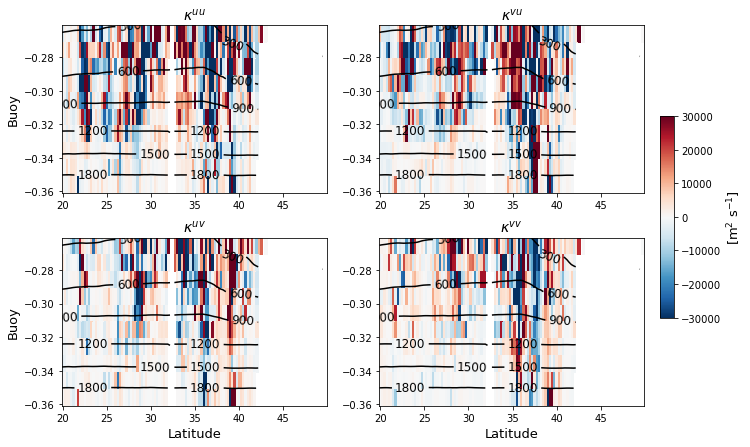

In [20]:
nlon = 295

fig, axes = plt.subplots(figsize=(11,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(K.YC, buoyb, K.sel(XC=nlon,method='nearest')[1,:,:,0,0],
                          vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs0 = axes[0,0].contour(zetab.YC, buoyb, -zetab.sel(XC=nlon,method='nearest').T,
                        colors='k')
axes[1,0].pcolormesh(K.YC, buoyb, K.sel(XC=nlon,method='nearest')[1,:,:,1,0],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs1 = axes[1,0].contour(zetab.YC, buoyb, -zetab.sel(XC=nlon,method='nearest').T,
                        colors='k')
axes[0,1].pcolormesh(K.YC, buoyb, K.sel(XC=nlon,method='nearest')[1,:,:,0,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs2 = axes[0,1].contour(zetab.YC, buoyb, -zetab.sel(XC=nlon,method='nearest').T,
                        colors='k')
axes[1,1].pcolormesh(K.YC, buoyb, K.sel(XC=nlon,method='nearest')[1,:,:,1,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs3 = axes[1,1].contour(zetab.YC, buoyb, -zetab.sel(XC=nlon,method='nearest').T,
                        colors='k')

for c in cs0.collections:
    c.set_rasterized(True)
for c in cs1.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)

axes[0,0].clabel(cs0, inline=1, fontsize=12, fmt='%1.f')
axes[1,0].clabel(cs1, inline=1, fontsize=12, fmt='%1.f')
axes[0,1].clabel(cs2, inline=1, fontsize=12, fmt='%1.f')
axes[1,1].clabel(cs3, inline=1, fontsize=12, fmt='%1.f')

axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=14)
axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=14)
axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=14)
axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=14)

axes[1,0].set_xlabel(r"Latitude", fontsize=13)
axes[1,1].set_xlabel(r"Latitude", fontsize=13)
axes[0,0].set_ylabel(r"Buoy", fontsize=13)
axes[1,0].set_ylabel(r"Buoy", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.27)
cbaxes = fig.add_axes([0.88, 0.3, 0.018, 0.4]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=13)

plt.savefig(op.join(ddir,'Figures/K_lon%2d_sig-Y_1964-Jan-01.pdf' % nlon))

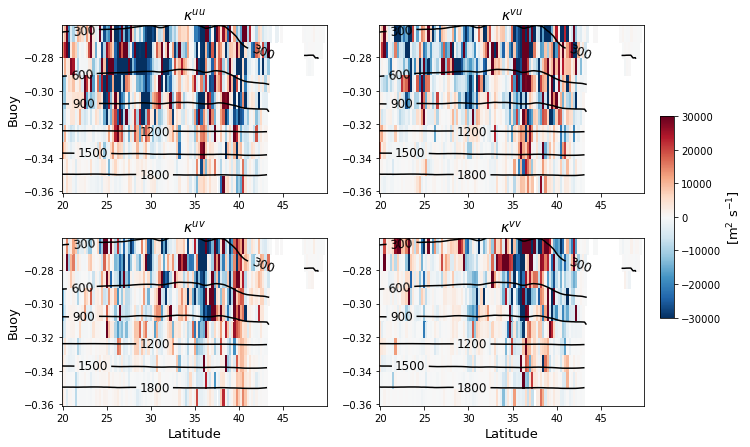

In [23]:
nlon = 300

fig, axes = plt.subplots(figsize=(11,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(K.YC, buoyb, K.sel(XC=nlon,method='nearest')[1,:,:,0,0],
                          vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs0 = axes[0,0].contour(zetab.YC, buoyb, -zetab.sel(XC=nlon,method='nearest').T,
                        colors='k')
axes[1,0].pcolormesh(K.YC, buoyb, K.sel(XC=nlon,method='nearest')[1,:,:,1,0],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs1 = axes[1,0].contour(zetab.YC, buoyb, -zetab.sel(XC=nlon,method='nearest').T,
                        colors='k')
axes[0,1].pcolormesh(K.YC, buoyb, K.sel(XC=nlon,method='nearest')[1,:,:,0,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs2 = axes[0,1].contour(zetab.YC, buoyb, -zetab.sel(XC=nlon,method='nearest').T,
                        colors='k')
axes[1,1].pcolormesh(K.YC, buoyb, K.sel(XC=nlon,method='nearest')[1,:,:,1,1],
                     vmax=3e4, vmin=-3e4, cmap='RdBu_r', rasterized=True)
cs3 = axes[1,1].contour(zetab.YC, buoyb, -zetab.sel(XC=nlon,method='nearest').T,
                        colors='k')

for c in cs0.collections:
    c.set_rasterized(True)
for c in cs1.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)

axes[0,0].clabel(cs0, inline=1, fontsize=12, fmt='%1.f')
axes[1,0].clabel(cs1, inline=1, fontsize=12, fmt='%1.f')
axes[0,1].clabel(cs2, inline=1, fontsize=12, fmt='%1.f')
axes[1,1].clabel(cs3, inline=1, fontsize=12, fmt='%1.f')

axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=14)
axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=14)
axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=14)
axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=14)

axes[1,0].set_xlabel(r"Latitude", fontsize=13)
axes[1,1].set_xlabel(r"Latitude", fontsize=13)
axes[0,0].set_ylabel(r"Buoy", fontsize=13)
axes[1,0].set_ylabel(r"Buoy", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.27)
cbaxes = fig.add_axes([0.88, 0.3, 0.018, 0.4]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=13)

plt.savefig(op.join(ddir,'Figures/K_lon%2d_sig-Y_1964-Jan-01.pdf' % nlon))

In [23]:
fC = xr.apply_ufunc(gsw.f, dsz.YC)
fG = xr.apply_ufunc(gsw.f, dsz.YG)
buoyb = -grav * dsmn.sig * rhoConst**-1
buoybp1 = -grav * dsmn.sigp1 * rhoConst**-1
sigma = dsz.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmay = dsz.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmax = dsz.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

zetab = (dsz.zdz*dsz.dzetaF**-1).mean('nmemb',skipna=True)
zetaxb = (dsz.zxdz*dsz.dzetaFx**-1).mean('nmemb',skipna=True)
zetayb = (dsz.zydz*dsz.dzetaFy**-1).mean('nmemb',skipna=True)


sigmab = (dsz.dzetaF.mean('nmemb',skipna=True) 
          * -grid.diff(buoybp1,'Z',boundary='fill')**-1
         )
sigmaxb = (dsz.dzetaFx.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
sigmayb = (dsz.dzetaFy.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
sigmazb = (dsz.dzetaFz.mean('nmemb',skipna=True) 
           * -grid.diff(buoybp1,'Z',boundary='fill')**-1
          )
    

vhat = dsmn.vdz.mean('nmemb',skipna=True) * dsz.dzetaFy.mean('nmemb',skipna=True)**-1
uhat = dsmn.udz.mean('nmemb',skipna=True) * dsz.dzetaFx.mean('nmemb',skipna=True)**-1


vort = (grid.diff(vhat*ds.dyC,'X') 
        - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
       ) * ds.rAz**-1


varpihat = (dspi.varpidz.mean('nmemb',skipna=True) 
            * dsz.dzetaF.mean('nmemb',skipna=True)**-1)

vpp = dsmn.vdz*dsz.dzetaFy**-1 - vhat
upp = dsmn.udz*dsz.dzetaFx**-1 - uhat
varpipp = (dspi.varpidz*dsz.dzetaF**-1 - varpihat)

zetap = (dsz.zdz*dsz.dzetaF**-1 - zetab) 
zetayp = (dsz.zydz*dsz.dzetaFy**-1 - zetayb)
zetaxp = (dsz.zxdz*dsz.dzetaFx**-1 - zetaxb)

mbx = dsmn.pxdz * dsz.dzetaFx**-1
mby = dsmn.pydz * dsz.dzetaFy**-1
mbxp = mbx - mbx.mean('nmemb',skipna=True)
mbyp = mby - mby.mean('nmemb',skipna=True)

tmp00 = ((upp**2*sigmax)
         + .5*(zetaxp**2)
        ).mean('nmemb',skipna=True)
tmp01 = (grid.interp(grid.interp(vpp,'X'),'Y',boundary='fill')
         * upp*sigmax).mean('nmemb',skipna=True)
tmp10 = (grid.interp(grid.interp(upp,'X'),'Y',boundary='fill') 
         * vpp*sigmay).mean('nmemb',skipna=True)
tmp11 = ((vpp**2*sigmay) 
         + .5*(zetayp**2)
        ).mean('nmemb',skipna=True)
tmp20 = ((varpipp*grid.interp(upp,'X')*sigma)
         + grid.interp(mbxp*zetaxp,'X')
        ).mean('nmemb',skipna=True)
tmp21 = ((varpipp*grid.interp(vpp,'Y',boundary='fill')*sigma)
         + grid.interp(mbyp*zetayp,'Y',boundary='fill')
        ).mean('nmemb',skipna=True)
tmp00_0 = (upp**2*sigmax).mean('nmemb',skipna=True)
tmp00_1 = .5*(zetaxp**2).mean('nmemb',skipna=True)
tmp11_0 = (vpp**2*sigmay).mean('nmemb',skipna=True)
tmp11_1 = .5*(zetayp**2).mean('nmemb',skipna=True)


e00 = dsep.e00
e10 = dsep.e10
e20 = dsep.e20
e01 = dsep.e01
e11 = dsep.e11
e21 = dsep.e21

Eu = dsdiv.e00x + dsdiv.e10y + dsdiv.e20b
Ev = dsdiv.e01x + dsdiv.e11y + dsdiv.e21b
PVpx = sigmab**-1 * Ev
PVpy = -sigmab**-1 * Eu

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [24]:
ny, nx, nb = (3,3,1)

def filt(da, nker=np.ones((ny,nx,nb))):
    return xr.DataArray(dsfilt.median_filter(da.data, footprint=nker), 
                        dims=da.dims, coords=da.coords)

#########################
def _dot(self, other):
    func = np.dot(self[0,0,0], other[0,0,0])
    return np.expand_dims(func, (0,1,2))

In [25]:
vort_sm = filt(vort.drop_vars('rAz').chunk({'YG':ychunk,'XG':xchunk}
                                          ), nker=np.ones((ny,nx,nb)))
zetaxb_sm = filt(zetaxb, nker=np.ones((ny,nx,nb)))
zetayb_sm = filt(zetayb, nker=np.ones((ny,nx,nb)))
sigmab_sm = filt(sigmab, nker=np.ones((ny,nx,nb)))

vortsm_x = grid.diff(vort_sm*grid.interp(ds.dyG,'Y',boundary='fill'),'X') * ds.rAs**-1
vortsm_y = grid.diff(vort_sm*grid.interp(ds.dxG,'X'),
                     'Y',boundary='fill') * ds.rAw**-1
vort_x = grid.diff(vort*grid.interp(ds.dyG,'Y',boundary='fill'),'X') * ds.rAs**-1
vort_y = grid.diff(vort*grid.interp(ds.dxG,'X'),
                   'Y',boundary='fill') * ds.rAw**-1

zetabsm_x = grid.diff(zetaxb_sm,'X')*grid.interp(ds.dxC,'X')**-1
zetabsm_y = (grid.diff(zetayb_sm,'Y',boundary='fill')
             * grid.interp(ds.dyC,'Y',boundary='fill')**-1)
zetab_x = grid.diff(zetaxb,'X')*grid.interp(ds.dxC,'X')**-1
zetab_y = grid.diff(zetayb,'Y',boundary='fill')*grid.interp(ds.dyC,'Y',boundary='fill')**-1


sigmabsm_x = grid.interp(grid.diff(zetabsm_x,'Z',boundary='fill') 
                         * grid.diff(buoyb,'Z',boundary='fill')**-1,
                         'Z',boundary='fill')
sigmabsm_y = grid.interp(grid.diff(zetabsm_y,'Z',boundary='fill') 
                         * grid.diff(buoyb,'Z',boundary='fill')**-1,
                         'Z',boundary='fill')
sigmab_x = grid.interp(grid.diff(zetab_x,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')
sigmab_y = grid.interp(grid.diff(zetab_y,'Z',boundary='fill') 
                       * grid.diff(buoyb,'Z',boundary='fill')**-1,
                       'Z',boundary='fill')


absvortsm = fC + grid.interp(grid.interp(vort_sm,'X'),'Y',boundary='fill')
Pism_xs = (grid.interp(vortsm_x,'Y',boundary='fill')
           - sigmab_x * sigmab_sm**-1 * absvortsm)
Pism_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
           + grid.interp(vortsm_y,'X')
          ) - sigmab_y * sigmab_sm**-1 * absvortsm
absvort = fC + grid.interp(grid.interp(vort,'X'),'Y',boundary='fill')
Pi_xs = (grid.interp(vort_x,'Y',boundary='fill')
         - sigmab_x * sigmab**-1 * absvort)
Pi_ys = (grid.diff(fG,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1 
         + grid.interp(vort_y,'X')
        ) - sigmab_y * sigmab**-1 * absvort


Pism_x = Pism_xs * sigmab_sm**-1
Pism_y = Pism_ys * sigmab_sm**-1
Pi_x = Pi_xs * sigmab**-1
Pi_y = Pi_ys * sigmab**-1


that = dsmn.tdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
shat = dsmn.sdz.mean('nmemb',skipna=True) * dsz.dzetaF.mean('nmemb',skipna=True)**-1
that_sm = filt(that, nker=np.ones((ny,nx,nb)))
shat_sm = filt(shat, nker=np.ones((ny,nx,nb)))

thatsm_x = grid.diff(that_sm,'X') * ds.dxC**-1
thatsm_y = grid.diff(that_sm,'Y',boundary='fill') * ds.dyC**-1
shatsm_x = grid.diff(shat_sm,'X') * ds.dxC**-1
shatsm_y = grid.diff(shat_sm,'Y',boundary='fill') * ds.dyC**-1
that_x = grid.diff(that,'X') * ds.dxC**-1
that_y = grid.diff(that,'Y',boundary='fill') * ds.dyC**-1
shat_x = grid.diff(shat,'X') * ds.dxC**-1
shat_y = grid.diff(shat,'Y',boundary='fill') * ds.dyC**-1

#########################################################
tpp = (dsmn.tdz * dsz.dzetaF**-1) - that
spp = (dsmn.sdz * dsz.dzetaF**-1) - shat
upptpphat = (upp*grid.interp(tpp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vpptpphat = (vpp*grid.interp(tpp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
uppspphat = (upp*grid.interp(spp,'X')*sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
vppspphat = (vpp*grid.interp(spp,'Y',boundary='fill')
             * sigmay).mean('nmemb',skipna=True) * sigmayb**-1

uptphat_sm = filt(upptpphat.chunk({'YC':ychunk,'XG':xchunk}), 
                  nker=np.ones((ny,nx,nb)))
vptphat_sm = filt(vpptpphat.chunk({'YG':ychunk,'XC':xchunk}), 
                  nker=np.ones((ny,nx,nb)))
upsphat_sm = filt(uppspphat.chunk({'YC':ychunk,'XG':xchunk}), 
                  nker=np.ones((ny,nx,nb)))
vpsphat_sm = filt(vppspphat.chunk({'YG':ychunk,'XC':xchunk}), 
                  nker=np.ones((ny,nx,nb)))
PVpx_sm = filt(PVpx, nker=np.ones((ny,nx,nb)))
PVpy_sm = filt(PVpy, nker=np.ones((ny,nx,nb)))

In [26]:
l = 6
ut = grid.interp(uptphat_sm.isel(sig=l),
                'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vt = grid.interp(vptphat_sm.isel(sig=l),
                'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
us = grid.interp(upsphat_sm.isel(sig=l),
                'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vs = grid.interp(vpsphat_sm.isel(sig=l),
                'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
uPV = PVpx_sm.isel(sig=l).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
vPV = PVpy_sm.isel(sig=l).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()

tx = grid.interp(thatsm_x.isel(sig=l),
                'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
ty = grid.interp(thatsm_y.isel(sig=l),
                'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
sx = grid.interp(shatsm_x.isel(sig=l),
                'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
sy = grid.interp(shatsm_y.isel(sig=l),
                'Y',boundary='fill').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
PVx = Pism_x.isel(sig=l).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
PVy = Pism_y.isel(sig=l).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
# dsfx = xr.open_dataset(op.join(ddir,'%4d/Normalized-fluxes_isig%2d-%2d_no-salt_%010d.nc' 
#                                % (year,sstart,send-1,itime)))
# ut_norm = dsfx.uptp
# vt_norm = dsfx.vptp
# uPV_norm = dsfx.upPVp
# vPV_norm = dsfx.vpPVp
# tx_norm = dsfx.tx
# ty_norm = dsfx.ty
# PVx_norm = dsfx.PVx
# PVy_norm = dsfx.PVy

In [ ]:
fig, axes = plt.subplots(figsize=(13,11), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           PVpx.isel(sig=l).sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp], 
                           vmin=-1e-10, vmax=1e-10, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           PVpy.isel(sig=l).sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp], 
                           vmin=-1e-10, vmax=1e-10, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           +(K.isel(time=0,sig=int(.5*l),row=0,col=0)
                             * PVx.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                             + K.isel(time=0,sig=int(.5*l),row=1,col=0)
                             * PVy.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]), 
                           vmin=-1e-10, vmax=1e-10, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           +(K.isel(time=0,sig=int(.5*l),row=0,col=1)
                             * PVx.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                             + K.isel(time=0,sig=int(.5*l),row=1,col=1)
                             * PVy.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]), 
                           vmin=-1e-10, vmax=1e-10, cmap='RdBu_r', rasterized=True)
im4 = axes[2,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           PVpx.isel(sig=l).sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                           - (K.isel(time=0,sig=int(.5*l),row=0,col=0)
                              * PVx.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                              + K.isel(time=0,sig=int(.5*l),row=1,col=0)
                              * PVy.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]), 
                           vmin=-1e-10, vmax=1e-10, cmap='RdBu_r', 
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)
im5 = axes[2,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           PVpy.isel(sig=l).sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                           - (K.isel(time=0,sig=int(.5*l),row=0,col=1)
                              * PVx.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                              + K.isel(time=0,sig=int(.5*l),row=1,col=1)
                              * PVy.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]),
                           vmin=-1e-10, vmax=1e-10, cmap='RdBu_r',
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)

axes[0,0].set_title(r"$\hat{u''\Pi''}$ $(= \overline{\sigma}^{-1}\overline{\bf e}_2$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[0,1].set_title(r"$\hat{v''\Pi''}$ $(= -\overline{\sigma}^{-1}\overline{\bf e}_1$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\Pi^\#_\tilde{x} + \kappa^{uv}\Pi^\#_\tilde{y})$", 
                    fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\Pi^\#_\tilde{x} + \kappa^{vv}\Pi^\#_\tilde{y})$", 
                    fontsize=14)
axes[2,0].set_title(r"Residual ($\hat{u''\Pi''}$)", 
                    fontsize=14)
axes[2,1].set_title(r"Residual ($\hat{v''\Pi''}$)", 
                    fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.89, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m s$^{-4}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/PV_param_isig19_1964-Jan-06_no-smoothness.pdf'))

In [ ]:
fig, axes = plt.subplots(figsize=(13,11), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           upptpphat.isel(sig=l).sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp], 
                           vmin=-1.4e-1, vmax=1.4e-1, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           vpptpphat.isel(sig=l).sel(YG=slice(yNstart+5,yend))[::nhskp,::nhskp], 
                           vmin=-1.4e-1, vmax=1.4e-1, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           (K.isel(time=0,sig=int(.5*l),row=0,col=0)
                            * tx.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                            + K.isel(time=0,sig=int(.5*l),row=1,col=0)
                            * ty.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]), 
                           vmin=-1.4e-1, vmax=1.4e-1, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           (K.isel(time=0,sig=int(.5*l),row=0,col=1)
                            * tx.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                            + K.isel(time=0,sig=int(.5*l),row=1,col=1)
                            * ty.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]), 
                           vmin=-1.4e-1, vmax=1.4e-1, cmap='RdBu_r', rasterized=True)
im4 = axes[2,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           grid.interp(upptpphat.isel(sig=l),'X'
                                      ).sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                           - (K.isel(time=0,sig=int(.5*l),row=0,col=0)
                              * tx.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                              + K.isel(time=0,sig=int(.5*l),row=1,col=0)
                              * ty.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]), 
                           vmin=-1.4e-1, vmax=1.4e-1, cmap='RdBu_r', 
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)
im5 = axes[2,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                           grid.interp(vpptpphat.isel(sig=l),'Y',
                                       boundary='fill').sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                           - (K.isel(time=0,sig=int(.5*l),row=0,col=1)
                              * tx.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]
                              + K.isel(time=0,sig=int(.5*l),row=1,col=1)
                              * ty.sel(YC=slice(yNstart+5,yend))[::nhskp,::nhskp]),
                           vmin=-1.4e-1, vmax=1.4e-1, cmap='RdBu_r',
#                            norm=clr.SymLogNorm(1e2), 
                           rasterized=True)

axes[0,0].set_title(r"$\hat{u''\theta''}$", 
                    fontsize=14)
axes[0,1].set_title(r"$\hat{v''\theta''}$", 
                    fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\hat{\theta}_\tilde{x}$"
                    + r"$+ \kappa^{uv}\hat{\theta}_\tilde{y})$", 
                    fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\hat{\theta}_\tilde{x}$"
                     + r"$+ \kappa^{vv}\hat{\theta}_\tilde{y})$", 
                    fontsize=14)
axes[2,0].set_title(r"Residual ($\hat{u''\theta''}$)", 
                    fontsize=14)
axes[2,1].set_title(r"Residual ($\hat{v''\theta''}$)", 
                    fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.89, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m $^\circ$C s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figures/Theta_param_isig19_1966-Jan-06_no-smoothness.pdf'))